In [1]:
# Input data files are available in the "../input/" directory. Files list: 
import pandas as pd
import os
for dirname, _, filenames in os.walk('../input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


../input/Titanic/test.csv
../input/Titanic/mytest_processed.csv
../input/Titanic/test_processed.csv
../input/Titanic/train_labels_example.csv
../input/Titanic/train_processed.csv
../input/Titanic/mytest_example_norm.csv
../input/Titanic/gender_submission.csv
../input/Titanic/mytest_labels_example.csv
../input/Titanic/mytest_example.csv
../input/Titanic/train_example.csv
../input/Titanic/train.csv
../input/Titanic/train_example_norm.csv


In [2]:
gender_submission = pd.read_csv("../input/Titanic/gender_submission.csv")
test = pd.read_csv("../input/Titanic/test.csv")
train = pd.read_csv("../input/Titanic/train.csv")

### Imports:

In [3]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib as mt
import matplotlib.pyplot as plt 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from IPython.display import display, HTML
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

### Visualization functions:

In [4]:
def plot_numeric_columns(dataframe, bins, fig_size=(14,20)):
    nplots = sum(train.dtypes=='int64') + sum(train.dtypes=='float64')   
    fig, axs = plt.subplots(nrows=int(np.ceil(nplots/4)), ncols=4, figsize=fig_size, squeeze=False)
    feature_list = train.columns.tolist()
    axsf = axs.flatten()
    ix = 0
    for k, ax in enumerate(feature_list):
        if k+1 > len(feature_list):
            break
        if train[feature_list[k]].dtypes=='int64' or train[feature_list[k]].dtypes=='float64':
            if train[feature_list[k]].nunique() < bins:
                nbins =  train[feature_list[k]].nunique()
            else:
                nbins = bins
            sns.distplot(train[feature_list[k]], bins=bins, ax=axsf[ix], kde=True)
            ix+=1
    fig.tight_layout()
    fig.show()
    
def plot_categorical_columns(dataframe, max_cat, fig_size=(14,20)):
    nplots = sum(train.dtypes=='object')
    fig, axs = plt.subplots(nrows=int(np.ceil(nplots/4)), ncols=4, figsize=fig_size, squeeze=False)
    feature_list = train.columns.tolist()
    axsf = axs.flatten()
    ix = 0
    for k, ax in enumerate(feature_list):
        if k+1 > len(feature_list):
            break
        if train[feature_list[k]].dtypes=='object':
            if train[feature_list[k]].nunique() < max_cat:
                train[feature_list[k]].value_counts().plot(kind="bar", ax=axsf[ix]).set_title(feature_list[k])
            else:
                train[feature_list[k]].value_counts().plot(ax=axsf[ix], xticks=[]).set_title(feature_list[k])
            ix+=1
    fig.tight_layout()
    fig.show()
    
def correlation_heatmap(dataframe, figsize=(12,8)):
    numcols = [x for x in dataframe.columns if dataframe[x].dtype=="int64" or dataframe[x].dtype=="float64"]
    plt.figure(figsize = figsize)
    sns.heatmap(data=dataframe[numcols].corr())
    plt.show()
    plt.gcf().clear()
    
def print_info(df):
    info = pd.concat([df.count(),df.nunique(), df.isnull().sum(axis = 0),df.dtypes, 
                      pd.DataFrame(np.transpose(df.values[10]),index=df.keys()),df.mean(axis=0), df.median(axis=0), 
                      df.min(axis=0), df.max(axis=0)], 
                      levels=None, axis=1, sort=False, ignore_index=False, 
                      keys=["Total", "Unique values", "NaNs", "Data type", "data example","mean", "median", "min", "max"])
    info = info.droplevel(1,axis=1)
    display(info)

### First look at the data:

In [5]:
df = train
print_info(df)

,Total,Unique values,NaNs,Data type,data example,mean,median,min,max
PassengerId,891,891,0,int64,11,446.000000,446.0000,1,891
Survived,891,2,0,int64,1,0.383838,0.0000,0,1
Pclass,891,3,0,int64,3,2.308642,3.0000,1,3
Name,891,891,0,object,"Sandstrom, Miss. Marguerite Rut",NaN,NaN,"Abbing, Mr. Anthony","van Melkebeke, Mr. Philemon"
Sex,891,2,0,object,female,NaN,NaN,female,male
Age,714,88,177,float64,4,29.699118,28.0000,0.42,80
SibSp,891,7,0,int64,1,0.523008,0.0000,0,8
Parch,891,7,0,int64,1,0.381594,0.0000,0,6
Ticket,891,681,0,object,PP 9549,NaN,NaN,110152,WE/P 5735
Fare,891,248,0,float64,16.7,32.204208,14.4542,0,512.329


In [6]:
df = test
print_info(df)

,Total,Unique values,NaNs,Data type,data example,mean,median,min,max
PassengerId,418,418,0,int64,902,1100.500000,1100.5000,892,1309
Pclass,418,3,0,int64,3,2.265550,3.0000,1,3
Name,418,418,0,object,"Ilieff, Mr. Ylio",NaN,NaN,"Abbott, Master. Eugene Joseph","van Billiard, Master. Walter John"
Sex,418,2,0,object,male,NaN,NaN,female,male
Age,332,79,86,float64,NaN,30.272590,27.0000,0.17,76
SibSp,418,7,0,int64,0,0.447368,0.0000,0,8
Parch,418,8,0,int64,0,0.392344,0.0000,0,9
Ticket,418,363,0,object,349220,NaN,NaN,110469,W.E.P. 5734
Fare,417,169,1,float64,7.8958,35.627188,14.4542,0,512.329
Cabin,91,76,327,object,NaN,NaN,NaN,NaN,NaN


Features distribution prior to any filtering or processing:


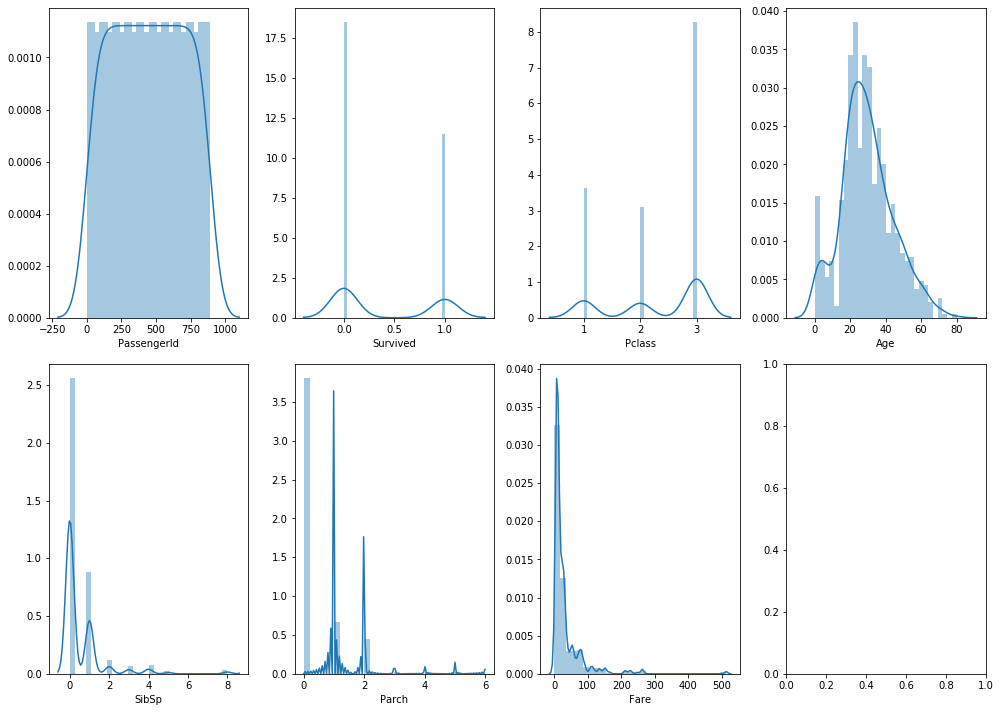

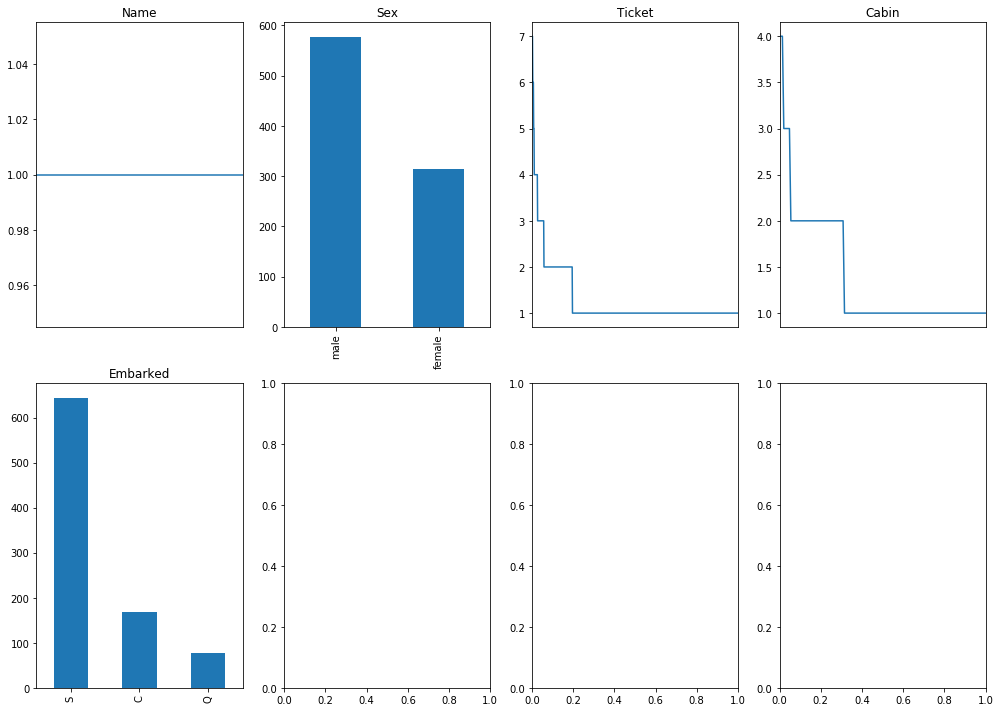

In [7]:
print('Features distribution prior to any filtering or processing:')
plot_numeric_columns(train, 30, (14,10))
plot_categorical_columns(train, 10, (14,10))

Correlation heat map for numerical features:


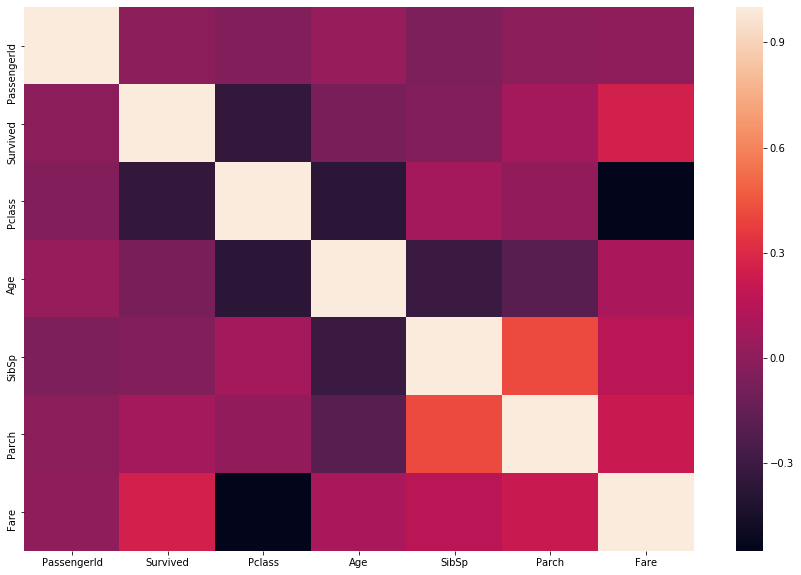

<Figure size 432x288 with 0 Axes>

In [8]:
print('Correlation heat map for numerical features:')
correlation_heatmap(train, (15,10))

## Preprocessing

In [9]:
# Split the training data to "training" and "mytest"
train, mytest = train_test_split(train, test_size=0.2, random_state=123)

datasets = [train, mytest, test]

In [58]:
mytest.iloc[43]

PassengerId                       484
Survived                            1
Pclass                              C
Name           Turkula, Mrs. (Hedwig)
Sex                            female
Age                                63
SibSp                               0
Parch                               0
Ticket                           4134
Fare                           9.5875
Cabin                               0
Embarked                            S
Name: 483, dtype: object

#### The feature cabin:
Some acquired information:
The allocation of cabins on the Titanic is a source of continuing interest and endless speculation.
Apart from the recollections of survivors and a few tickets and boarding cards, the only authoritative 
source of cabin data is the incomplete first class passenger list recovered with the body of steward 
Herbert Cave.

So, we will transform it into binary!


In [10]:
 for df in datasets:
    df['Cabin'].where(df['Cabin'].isnull(), 1, inplace=True)
    df['Cabin'].where(~df['Cabin'].isnull(), 0, inplace=True)

In [11]:
# SAY WHATTT - Very interesting data leackage!
sc = datasets[0]['Survived'].loc[(datasets[0]['Cabin'].values==1) & ~(datasets[0]['Pclass'].values==1)]
snc = datasets[0]['Survived'].loc[(datasets[0]['Cabin'].values==0) & ~(datasets[0]['Pclass'].values==1)]

print(f'Precentage of survived out the ones that have a cabin and are not first class {sum(sc)*100/len(sc)}')
print(f'Precentage of survived out the ones that dont have a cabin and are not first class {sum(snc)*100/len(snc)}')

Precentage of survived out the ones that have a cabin and are not first class 72.72727272727273
Precentage of survived out the ones that dont have a cabin and are not first class 29.770992366412212


#### The feature Fare:
One missing in the test set. will be filled using mean.

In [12]:
print('Fill the test data NaN in Fare category using mean')
fare_mean = np.round(test['Fare'].mean())
null_inx = test['Fare'].isnull()
test['Fare'].fillna(fare_mean, inplace=True)
test.loc[null_inx]

Fill the test data NaN in Fare category using mean


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,36.0,0,S


#### The feature Pclass:
Transform into categoric for later one got encoding

In [13]:
print('The unique values within Pclass in the different datasets:')
for df in datasets:
    print(df['Pclass'].unique())


The unique values within Pclass in the different datasets:
[1 3 2]
[3 1 2]
[3 2 1]


In [14]:
for df in datasets:
    df['Pclass'] = df['Pclass'].map({1:'A', 2:'B', 3:'C'})
print('Values within Pclass mapped succesfully')

Values within Pclass mapped succesfully


In [15]:
print('The unique values within Pclass in the different datasets:')
for df in datasets:
    print(df['Pclass'].unique())

The unique values within Pclass in the different datasets:
['A' 'C' 'B']
['C' 'A' 'B']
['C' 'B' 'A']


#### Extract title and remove name:

In [16]:
datasets_eng = []
for df in datasets:
    df_eng = df.copy(deep=True)
    titles = df_eng['Name'].str.split(',', expand=True)[1].str.split('.', expand=True)[0]
    df_eng = df_eng.join(titles.rename('Title'))
    df_eng.drop(labels = ["Name"], axis = 1, inplace = True)
    datasets_eng.append(df_eng)

In [17]:
for df in datasets_eng:
    print(len(df))

712
179
418


In [18]:
datasets_eng[0]['Title'].value_counts()

 Mr              419
 Miss            151
 Mrs              95
 Master           30
 Dr                4
 Rev               4
 Mlle              1
 Ms                1
 the Countess      1
 Lady              1
 Major             1
 Col               1
 Capt              1
 Mme               1
 Don               1
Name: Title, dtype: int64

### Fill NaNs in the datasets:

#### functions

In [19]:
# Functions:

def fillna_reg(df, base, target):
    nonmissing_inx = ~df[target].isnull()
    missing_inx = df[target].isnull()
    base_df = df[base]
    base_df_enc = pd.get_dummies(base_df)
    target_df = df[target]
    
    train_base = base_df_enc[nonmissing_inx]
    train_target = target_df[nonmissing_inx]
    predict_base = base_df_enc[missing_inx]
    
    regressor = LinearRegression()
    regressor.fit(train_base.values, train_target.values.reshape(-1, 1))  #training the regressor
    
    produced_labels_RG = regressor.predict(predict_base.values) # predict
    df.loc[missing_inx, target] = produced_labels_RG  # fill the nan values
    
def zoningcode2int( df, target ):
    storenull = df[ target ].isnull()
    enc = LabelEncoder( )
    df[ target ] = df[ target ].astype( str )

    print(f'fit and transform string variable {target} to encoded int')
    df[ target ]= enc.fit_transform( df[ target ].values )
    print( 'num of categories: ', enc.classes_.shape  )
    df.loc[ storenull, target ] = np.nan
    print('recover the nan value')
    return enc


#### Imputing:

In [20]:
# Embarked:
n = 5
for ix, df in enumerate(datasets_eng):
    if df["Embarked"].isnull().sum() > 0:
        print(f'Number of NaNs in Embarked column in dataset before imputing: {df["Embarked"].isnull().sum()}')
        df["Embarked"] = df["Embarked"].fillna(df['Embarked'].value_counts().index[0]) 
        datasets_eng[ix] = df
        print(f'Number of NaNs left in Embarked column in dataset: {df["Embarked"].isnull().sum()}')
        

Number of NaNs in Embarked column in dataset before imputing: 2
Number of NaNs left in Embarked column in dataset: 0


In [21]:
# Age:
for ix, df in enumerate(datasets_eng):
    print(f'Number of NaNs in Age column in dataset before imputing: {df["Age"].isnull().sum()}')
    fillna_reg(df, base=['Title', 'Fare', 'Sex', 'Pclass'], target='Age')
    print(f'Number of NaNs left in Age column in dataset: {df["Age"].isnull().sum()}')

Number of NaNs in Age column in dataset before imputing: 148
Number of NaNs left in Age column in dataset: 0
Number of NaNs in Age column in dataset before imputing: 29
Number of NaNs left in Age column in dataset: 0
Number of NaNs in Age column in dataset before imputing: 86
Number of NaNs left in Age column in dataset: 0


In [22]:
for ix, df in enumerate(datasets_eng):
    print_info(df)

,Total,Unique values,NaNs,Data type,data example,mean,median,min,max
PassengerId,712,712,0,int64,157,444.398876,444.500000,1,891
Survived,712,2,0,int64,1,0.389045,0.000000,0,1
Pclass,712,3,0,object,C,NaN,NaN,A,C
Sex,712,2,0,object,female,NaN,NaN,female,male
Age,712,162,0,float64,16,29.534731,29.377789,0.42,80
SibSp,712,7,0,int64,0,0.512640,0.000000,0,8
Parch,712,6,0,int64,0,0.363764,0.000000,0,5
Ticket,712,576,0,object,35851,NaN,NaN,110152,WE/P 5735
Fare,712,225,0,float64,7.7333,32.388400,13.500000,0,512.329
Cabin,712,2,0,object,0,0.219101,0.000000,0,1


,Total,Unique values,NaNs,Data type,data example,mean,median,min,max
PassengerId,179,179,0,int64,148,452.368715,453.000000,5,889
Survived,179,2,0,int64,0,0.363128,0.000000,0,1
Pclass,179,3,0,object,C,NaN,NaN,A,C
Sex,179,2,0,object,female,NaN,NaN,female,male
Age,179,83,0,float64,9,29.291584,27.782595,0.75,65
SibSp,179,6,0,int64,2,0.564246,0.000000,0,5
Parch,179,7,0,int64,2,0.452514,0.000000,0,6
Ticket,179,166,0,object,W./C. 6608,NaN,NaN,111240,W./C. 6608
Fare,179,106,0,float64,34.375,31.471556,18.750000,0,247.521
Cabin,179,2,0,object,0,0.268156,0.000000,0,1


,Total,Unique values,NaNs,Data type,data example,mean,median,min,max
PassengerId,418,418,0,int64,902,1100.500000,1100.500000,892,1309
Pclass,418,3,0,object,C,NaN,NaN,A,C
Sex,418,2,0,object,male,NaN,NaN,female,male
Age,418,134,0,float64,28.0385,29.615738,28.034534,0.17,76
SibSp,418,7,0,int64,0,0.447368,0.000000,0,8
Parch,418,8,0,int64,0,0.392344,0.000000,0,9
Ticket,418,363,0,object,349220,NaN,NaN,110469,W.E.P. 5734
Fare,418,170,0,float64,7.8958,35.628080,14.454200,0,512.329
Cabin,418,2,0,object,0,0.217703,0.000000,0,1
Embarked,418,3,0,object,S,NaN,NaN,C,S


## Concatenate all, map rare and one-hot-encode:

In [37]:
train_len = len(train)
mytest_len = len(mytest)
comb_dataset = pd.concat(objs=[datasets_eng[0],datasets_eng[1], datasets_eng[2]], axis=0).reset_index(drop=True)

# group rare titles together
comb_dataset.loc[comb_dataset['Title'].value_counts()[comb_dataset['Title']].values < 4, 'Title'] = "Other"

do_ohe = False
if do_ohe:
   #one hot encoding
    comb_dataset = pd.get_dummies(comb_dataset, columns = ["Pclass"],prefix="Pclass")
    comb_dataset = pd.get_dummies(comb_dataset, columns = ["Embarked"],prefix="Embarked")
    comb_dataset = pd.get_dummies(comb_dataset, columns = ["Title"],prefix="Title")
else:
   #label encoding:
    for feature in ["Embarked", "Pclass", "Title"]:
        le = LabelEncoder()
        le.fit(comb_dataset[feature])
        comb_dataset[feature] = le.transform(comb_dataset[feature])

#map sex to categorical:
comb_dataset["Sex"] = comb_dataset["Sex"].map({"male": 0, "female":1})

#drop ticket (too many categories, not much correlation):
comb_dataset.drop(labels = ["Ticket"], axis = 1, inplace = True)

In [38]:
comb_dataset.head()

,Age,Cabin,Embarked,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Title
0,16.0,1,0,57.9792,1,330,0,1,0,1.0,3
1,31.0,0,1,7.7500,0,750,2,0,0,0.0,4
2,45.5,0,0,7.2250,0,204,2,0,0,0.0,4
3,21.0,0,1,7.7333,0,422,2,0,0,0.0,4
4,23.0,1,0,63.3583,1,98,0,0,0,1.0,4


In [39]:
comb_dataset['Title'].unique()

array([3, 4, 5, 2, 1, 6, 7, 0])

In [40]:
# Split back
train_final = comb_dataset[:train_len]
mytest_final = comb_dataset[train_len:train_len+mytest_len]
test_final = comb_dataset[train_len+mytest_len:]

In [41]:
print('Writing processed datasets to csv')
if do_ohe:
    train_final.to_csv("../input/Titanic/train_processed.csv", index=False)
    mytest_final.to_csv("../input/Titanic/mytest_processed.csv", index=False)
    test_final.to_csv("../input/Titanic/test_processed.csv", index=False)
else:
    train_final.to_csv("../input/Titanic/train_processed_nonohe.csv", index=False)
    mytest_final.to_csv("../input/Titanic/mytest_processed_nonohe.csv", index=False)
    test_final.to_csv("../input/Titanic/test_processed_nonohe.csv", index=False)

Writing processed datasets to csv
